In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt
import datetime as dt
import yfinance as yf
import seaborn as sns
import numpy as np

In [2]:
start = '2008-01-01'
end = dt.datetime.today()
nifty_symbol = '^NSEI'
usd_symbol = 'INR=X'
nifty_data = yf.download(nifty_symbol,start=start,end=end)['Close']
usd_data = yf.download(usd_symbol,start=start,end=end)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
nifty_data.columns = ['Close']
usd_data.columns = ['Close']

In [4]:
df = nifty_data.copy()

In [5]:
df.head()

,Close
Date,
2008-01-01,6144.350098
2008-01-02,6179.399902
2008-01-03,6178.549805
2008-01-04,6274.299805
2008-01-07,6279.100098


In [6]:
df = pd.merge(df,usd_data,how='left',left_index=True,right_index=True)
df.rename(columns={'Close_x':'Nifty','Close_y':'USD'},inplace=True)
df['USD'] = df['USD'].ffill()

In [7]:
print(df.shape)
df.head()

(4208, 2)


,Nifty,USD
Date,,
2008-01-01,6144.350098,39.244999
2008-01-02,6179.399902,39.375000
2008-01-03,6178.549805,39.353001
2008-01-04,6274.299805,39.095001
2008-01-07,6279.100098,39.213001


In [8]:
df.isnull().sum()

Nifty    0
USD      0
dtype: int64

Text(0.5, 1.0, 'USD Closing Price')

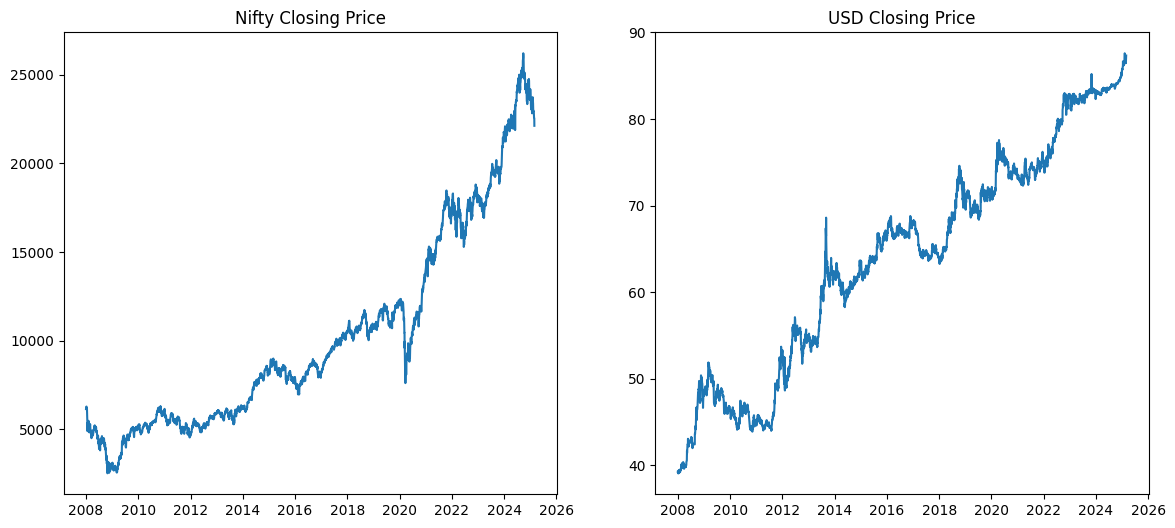

In [9]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(df['Nifty'])
plt.title("Nifty Closing Price")

plt.subplot(1,2,2)
plt.plot(df['USD'])
plt.title("USD Closing Price")

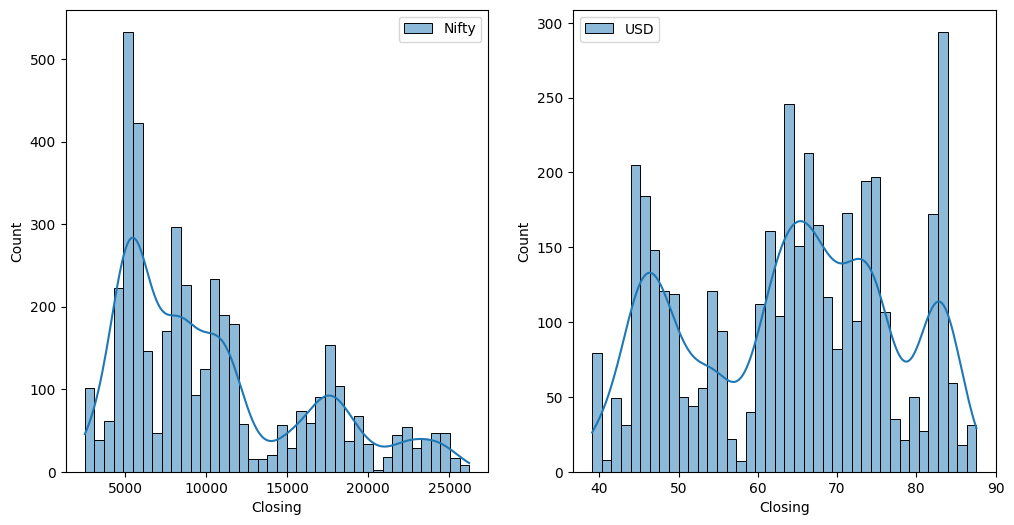

In [10]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.histplot(df['Nifty'],kde=True,bins=40,label='Nifty')
plt.xlabel('Closing')
plt.ylabel('Count')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(df['USD'],kde=True,bins=40,label='USD')
plt.xlabel('Closing')
plt.ylabel('Count')
plt.legend()
plt.show();

In [11]:
def Nifty_USD_strategy(data):
    df = data.copy()
    
    df['Nifty_returns'] = df['Nifty'].pct_change(fill_method=None)
    df['USD_returns'] = df['USD'].pct_change(fill_method=None)

    df['Nifty_net'] = df['Nifty_returns'].rolling(window=21).mean() / df['Nifty_returns'].rolling(window=21).std()
    df['USD_net'] = df['USD_returns'].rolling(window=21).mean() / df['USD_returns'].rolling(window=21).std()

    df.dropna(axis=0,inplace=True)

    df['Regime'] = (df['Nifty_net'] > df['USD_net']).astype(int)

    return df
    

In [12]:
sample_df = Nifty_USD_strategy(df)
sample_df.head()

,Nifty,USD,Nifty_returns,USD_returns,Nifty_net,USD_net,Regime
Date,,,,,,,
2008-01-30,5167.600098,39.347000,-0.021436,0.003494,-0.223671,0.042878,0
2008-01-31,5137.450195,39.313999,-0.005834,-0.000839,-0.240671,-0.024109,0
2008-02-01,5317.250000,39.272999,0.034998,-0.001043,-0.184753,-0.032003,0
2008-02-04,5463.500000,39.271999,0.027505,-0.000025,-0.166360,0.087349,0
2008-02-05,5483.899902,39.451000,0.003734,0.004558,-0.162257,0.111932,0


Below is the Inverse Correlation Between Nifty and USD normalized returns.

We can see that when Nifty returns are up USD returns are down and vice versa.

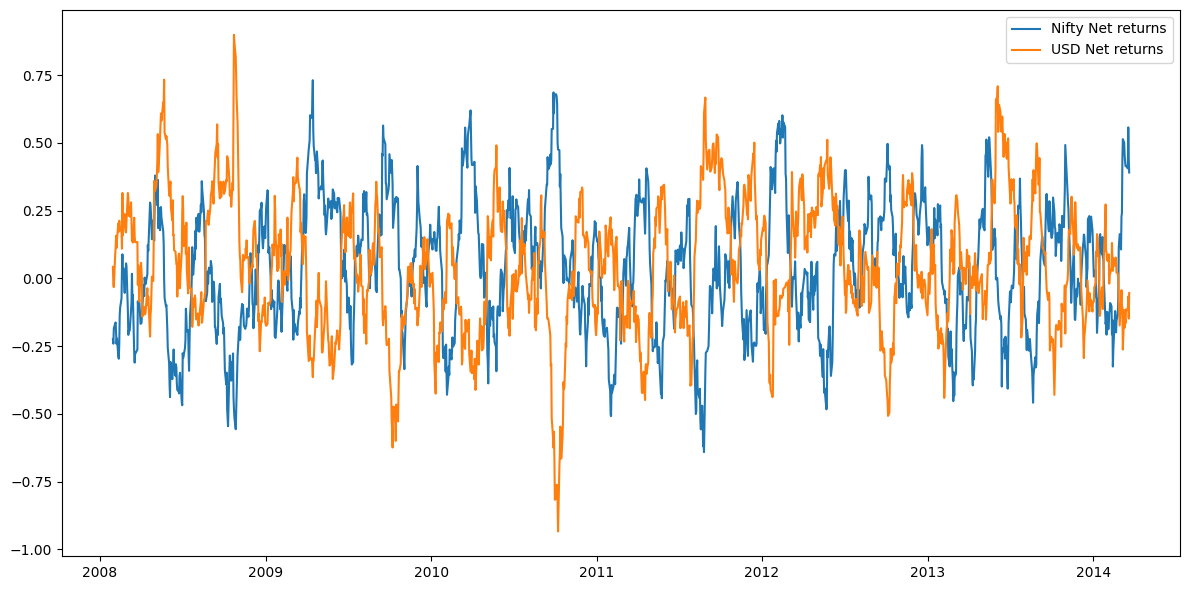

In [13]:
plt.figure(figsize=(12,6))
plt.plot(sample_df['Nifty_net'].head(1500),label='Nifty Net returns')
plt.plot(sample_df['USD_net'].head(1500),label='USD Net returns ')
plt.legend()
plt.tight_layout()
plt.show()

Below visualization show that both Nifty and USD returns have similar central tendancies.

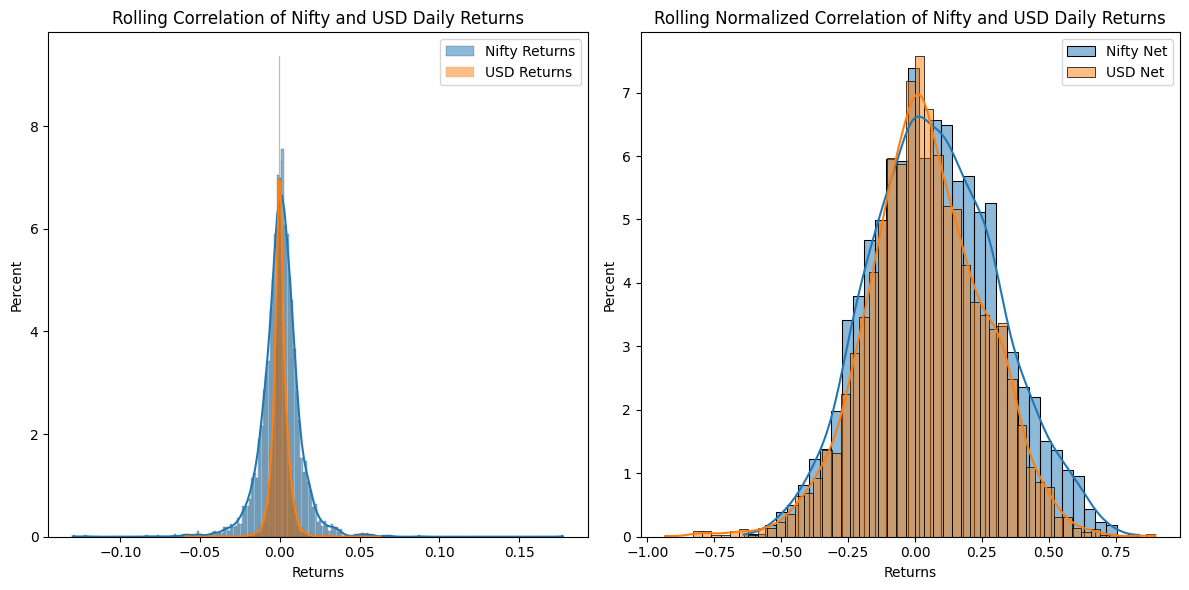

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.histplot(sample_df['Nifty_returns'],kde=True,label = 'Nifty Returns', stat='percent')
sns.histplot(sample_df['USD_returns'],kde=True,label = 'USD Returns', stat='percent')
plt.title("Rolling Correlation of Nifty and USD Daily Returns")
plt.xlabel("Returns")
plt.ylabel("Percent")
plt.legend()


plt.subplot(1,2,2)
sns.histplot(sample_df['Nifty_net'],kde=True,label='Nifty Net',stat='percent')
sns.histplot(sample_df['USD_net'],kde=True,label='USD Net',stat='percent')
plt.title("Rolling Normalized Correlation of Nifty and USD Daily Returns")
plt.xlabel("Returns")
plt.ylabel("Percent")
plt.legend()

plt.tight_layout()
plt.show()


BACKTESTING

In [15]:
class nifty_usd_backtesting:
    def __init__(self,data,window,stop_loss):
        self.data = data
        self.window = window
        self.stop_loss = stop_loss 
        
    def strategy(self):
        nifty_close = self.data['Nifty']
        usd_close = self.data['USD']

        nifty_returns = nifty_close.pct_change().dropna()
        usd_returns = usd_close.pct_change().dropna()

        nifty_net = nifty_returns.rolling(window=self.window).mean() / nifty_returns.rolling(window=self.window).std()
        usd_net = usd_returns.rolling(window=self.window).mean() / usd_returns.rolling(window=self.window).std()

        Regime = np.where(nifty_net > usd_net,1,0)
        
        return pd.Series(Regime,index = nifty_returns.index)

    def backtest(self):
        regime_df = self.strategy()
        
        entry = regime_df == 1
        exit = regime_df == 0

        entry = entry.reindex(self.data.index,method='bfill')
        exit = exit.reindex(self.data.index,method='bfill')
        portfolio = vbt.Portfolio.from_signals(
                close = self.data['Nifty'],
                entries = entry,
                exits = exit,
                sl_stop = self.stop_loss,
                freq = '1D',
                init_cash = 100000
        )
        return portfolio

    def calculate_performance_metrics(self,portfolio):
        
        total_returns = portfolio.total_return()
        sharpe_ratio = portfolio.sharpe_ratio()
        max_drawdown = portfolio.max_drawdown()
        annualized_return = portfolio.annualized_return()
        win_rate = portfolio.stats()['Win Rate [%]']

        return {
            'Window': self.window,
            'sl_stop': self.stop_loss,
            'Total Returns': total_returns,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Annualized Returns': annualized_return,
            'Win Rate':win_rate
        }

In [16]:
windows = np.arange(14,80,1)
stop_losses = [0.03,0.04,0.05,0.07,0.09]
result_df = []
for sl_stop in stop_losses:
    for window in windows:
        backtester = nifty_usd_backtesting(data=df,window=window,stop_loss=sl_stop)
    
        signals = backtester.strategy()
    
        portfolio = backtester.backtest()
    
        metrics = backtester.calculate_performance_metrics(portfolio)
    
        result_df.append(metrics)

In [17]:
metrics_df = pd.DataFrame(result_df)

max_return = metrics_df.loc[metrics_df['Total Returns'].idxmax()]
high_win_rate = metrics_df.loc[metrics_df['Win Rate'].idxmax()]
max_annual_returns = metrics_df.loc[metrics_df['Annualized Returns'].idxmax()]

print("Highest Returns:")
print('-------------------------------')
print(max_return)
print('\n')
print("Highest win rate:")
print('-------------------------------')
print(high_win_rate)
print('\n')
print("Max Annualized returns:")
print('-------------------------------')
print(max_annual_returns)

Highest Returns:
-------------------------------
Window                16.000000
sl_stop                0.030000
Total Returns          4.877828
Sharpe Ratio           1.107369
Max Drawdown          -0.179665
Annualized Returns     0.166062
Win Rate              45.128205
Name: 2, dtype: float64


Highest win rate:
-------------------------------
Window                72.000000
sl_stop                0.070000
Total Returns          3.312593
Sharpe Ratio           0.953991
Max Drawdown          -0.184095
Annualized Returns     0.135160
Win Rate              57.009346
Name: 256, dtype: float64


Max Annualized returns:
-------------------------------
Window                16.000000
sl_stop                0.030000
Total Returns          4.877828
Sharpe Ratio           1.107369
Max Drawdown          -0.179665
Annualized Returns     0.166062
Win Rate              45.128205
Name: 2, dtype: float64


From the above result we can see that window with size 16 give the maximum total returns & annualized returns 

In [18]:
final_backtester = nifty_usd_backtesting(df,window=16,stop_loss=0.03)
strategy = final_backtester.strategy()
portfolio = final_backtester.backtest()

In [19]:
print(f"Annualized returns: {portfolio.annualized_return():.3f}")
portfolio.stats()

Annualized returns: 0.166


Start                                2008-01-01 00:00:00
End                                  2025-02-28 00:00:00
Period                                4208 days 00:00:00
Start Value                                     100000.0
End Value                                  587782.842851
Total Return [%]                              487.782843
Benchmark Return [%]                          260.082008
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                               17.966458
Max Drawdown Duration                  372 days 00:00:00
Total Trades                                         195
Total Closed Trades                                  195
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   45.128205
Best Trade [%]                                 44.610362
Worst Trade [%]                

In [20]:
portfolio.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '6096a4ad-3d6e-4921-8748-d230452ca256',
              'x': array([datetime.datetime(2008, 1, 1, 0, 0),
                          datetime.datetime(2008, 1, 2, 0, 0),
                          datetime.datetime(2008, 1, 3, 0, 0), ...,
                          datetime.datetime(2025, 2, 25, 0, 0),
                          datetime.datetime(2025, 2, 27, 0, 0),
                          datetime.datetime(2025, 2, 28, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 6144.35009766,  6179.39990234,  6178.54980469, ..., 22547.55078125,
                          22545.05078125, 22124.69921875]),
              'yaxis': 'y'},
             {'customdata': array([[  0.        ,  20.23472278,   0.        ],
                                   [  2.        ,  20.2

In [21]:
trade_log = portfolio.trades.records
entry_idx = trade_log['entry_idx']
exit_idx = trade_log['exit_idx']

entry_date = df.index[entry_idx]
exit_date = df.index[exit_idx]

trade_log['Entry_Date'] = entry_date
trade_log['Exit_Date'] = exit_date

trade_log['Profit/Loss'] = np.where(trade_log['entry_price'] < trade_log['exit_price'],'Profit','Loss')

In [22]:
trade_log['Profit/Loss'].value_counts()

Profit/Loss
Loss      107
Profit     88
Name: count, dtype: int64

In [23]:
trade_log.head(10)

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id,Entry_Date,Exit_Date,Profit/Loss
0,0,0,20.234723,60,4942.000000,0.0,61,4734.500000,0.0,-4198.704978,-0.041987,0,1,0,2008-03-28,2008-03-31,Loss
1,1,0,20.213163,62,4739.549805,0.0,76,5022.799805,0.0,5725.378556,0.059763,0,1,1,2008-04-01,2008-04-23,Profit
2,2,0,20.305943,77,4999.850098,0.0,84,5144.649902,0.0,2940.296652,0.028961,0,1,2,2008-04-24,2008-05-06,Profit
3,3,0,25.115271,137,4159.500000,0.0,155,4430.700195,0.0,6811.266434,0.065200,0,1,3,2008-07-21,2008-08-14,Profit
4,4,0,25.976221,159,4283.850098,0.0,160,4327.450195,0.0,1132.565770,0.010178,0,1,4,2008-08-21,2008-08-22,Profit
5,5,0,37.533449,208,2994.949951,0.0,209,2892.649902,0.0,-3839.673706,-0.034158,0,1,5,2008-11-05,2008-11-06,Loss
6,6,0,34.486184,211,3148.250000,0.0,212,2938.649902,0.0,-7228.307531,-0.066577,0,1,6,2008-11-10,2008-11-11,Loss
7,7,0,37.625656,219,2693.449951,0.0,220,2708.250000,0.0,556.861545,0.005495,0,1,7,2008-11-21,2008-11-24,Profit
8,8,0,34.798833,230,2928.250000,0.0,248,2920.399902,0.0,-273.174237,-0.002681,0,1,8,2008-12-10,2009-01-07,Loss
9,9,0,36.255688,266,2803.050049,0.0,276,2776.149902,0.0,-975.283323,-0.009597,0,1,9,2009-02-04,2009-02-18,Loss
